In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
import seaborn as sns
import sklearn.metrics as metrics
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import roc_curve, auc
import catboost
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
loan_df = pd.read_csv('data/loan_result.csv')
# log_data = pd.read_csv('data/log_Data.csv')
user_df = pd.read_csv('data/user_spec.csv')

In [3]:
loan_df.columns = ["신청서_번호","한도조회_일시","금융사_번호","상품번호","승인한도","승인금리","신청_여부(타겟)"]
loan_df.head()

,신청서_번호,한도조회_일시,금융사_번호,상품번호,승인한도,승인금리,신청_여부(타겟)
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN


In [4]:
loan_df['승인한도'] = loan_df['승인한도']/10000
loan_df = loan_df[["신청서_번호","금융사_번호","상품번호","승인한도","승인금리","신청_여부(타겟)"]]

In [6]:
user_df.columns = ["신청서_번호","유저_번호","유저_생년월일","유저_성별","생성일시","한도조회_당시_유저_신용점수",
                  "연소득","근로형태","입사연월","고용형태","주거소유형태","대출희망금액","대출_목적",
                  "개인회생자_여부","개인회생자_납입_완료_여부","기대출수","기대출금액"]

In [7]:
# 승인한도가 없는 데이터 삭제하기
loan_df_null = loan_df[loan_df["승인한도"].isnull()]

In [8]:
loan_df = loan_df[loan_df['승인한도'].notnull()]

In [9]:
user_df_drop_list = set(loan_df_null['신청서_번호'])
user_df.drop(user_df[user_df['신청서_번호'].isin(user_df_drop_list)].index,inplace=True)
user_df.sort_values(by = '생성일시',ascending = True,inplace = True)# 날짜순서로 sort
user_df.reset_index(drop = True,inplace = True)

### 85개의 결측 빼기
- 대출_목적, 희망금액 ... 등 결측치가 많은 85명 우선적으로 처리하기

In [11]:
user_df = user_df[user_df["대출_목적"].notnull()]

In [12]:
user_df.isnull().sum()

신청서_번호                   0
유저_번호                    0
유저_생년월일              12901
유저_성별                12901
생성일시                     0
한도조회_당시_유저_신용점수     104456
연소득                      5
근로형태                     0
입사연월                170541
고용형태                     0
주거소유형태                   0
대출희망금액                   0
대출_목적                    0
개인회생자_여부            584593
개인회생자_납입_완료_여부     1196795
기대출수                197556
기대출금액               312309
dtype: int64

### 개인회생자 처리하기

In [13]:
user_df.loc[(user_df['개인회생자_여부']==0)&
                      (user_df['개인회생자_납입_완료_여부']==1),'개인회생자_납입_완료_여부']=0 # 개인회생자가 아니면서 납입완료된 유저는 3명 -> 완료여부 0으로 변경

user_df.loc[(user_df['개인회생자_여부']==0)&
                      (user_df['개인회생자_납입_완료_여부'].isnull()),'개인회생자_납입_완료_여부'] = 0

In [14]:
user_df['개인회생자'] = 10 #null값인 데이터는 처리 못한 상황

user_df.loc[(user_df['개인회생자_여부']==0)
                      &(user_df['개인회생자_납입_완료_여부']==0),'개인회생자'] = 0

user_df.loc[(user_df['개인회생자_여부']==1)
                      &(user_df['개인회생자_납입_완료_여부']==0),'개인회생자'] = 1

user_df.loc[(user_df['개인회생자_여부']==1)
                      &(user_df['개인회생자_납입_완료_여부']==1),'개인회생자'] = 2

### 신용점수 등급추가하기

In [16]:
bins = [0, 444, 514, 599, 664, 749, 804, 839, 869, 899, 1000]
#labels = ['null', '10등급', '9등급', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
labels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


user_df['신용점수등급'] = pd.cut(user_df['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)
user_df.loc[user_df['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

### 성별 결측치 채우기

이미 기존의 데이터에 성별 및 생년월일이 존재한다면 대체

In [19]:
sex_null_list = set(user_df[(user_df['유저_번호'].isin(
    set(user_df[user_df['유저_성별'].isnull()]['유저_번호'])))&(user_df['유저_성별'].notnull())]['유저_번호'])
for i in sex_null_list:
    user_df.loc[(user_df['유저_번호']==i)&(user_df['유저_생년월일'].isnull()),
                  '유저_생년월일'] = user_df[user_df['유저_번호'] ==i]['유저_생년월일'].dropna().unique().item()
    user_df.loc[(user_df['유저_번호']==i)&(user_df['유저_성별'].isnull()),
                  '유저_성별'] = user_df[user_df['유저_번호'] ==i]['유저_성별'].dropna().unique().item()

In [20]:
train_data = user_df.dropna(how = 'any')[["유저_성별","연소득","근로형태","고용형태","주거소유형태","대출희망금액","대출_목적",
                                             "개인회생자"]]


test_data = user_df[user_df["유저_성별"].isnull()][["유저_성별","연소득","근로형태",
                                                       "고용형태","주거소유형태","대출희망금액","대출_목적","개인회생자"]]
test_data.head(3)

,유저_성별,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출_목적,개인회생자
58,NaN,24000000.0,EARNEDINCOME,정규직,전월세,30000000.0,대환대출,10
99,NaN,30000000.0,EARNEDINCOME,정규직,전월세,3000000.0,생활비,10
114,NaN,30000000.0,EARNEDINCOME,정규직,전월세,10000000.0,생활비,10


In [21]:
data = pd.concat([train_data,test_data],axis=0)
data.shape

(563549, 8)

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

le = LabelEncoder()
for col in ["고용형태","주거소유형태","대출_목적","근로형태"]:
    data[col] = le.fit_transform(data[col])

for col in ["연소득","대출희망금액"]:
    data[col] = np.log1p(data[col])   
    
train_data = data.iloc[:553869,:]    
test_data = data.iloc[553869:,:]    
    
features_train = train_data.drop("유저_성별",axis=1)
labels_train = train_data["유저_성별"]

features_test = test_data.drop("유저_성별",axis=1)
labels_test = test_data["유저_성별"]

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

X_train, X_test, y_train, y_test = train_test_split(features_train,labels_train,
                                                    random_state=0,test_size=0.2,shuffle=True,stratify=labels_train)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [100,1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

grid_search.fit(X_train, y_train)
print('test accuracy : ', grid_search.score(X_test, y_test))
print('최적의 parameters : ', grid_search.best_params_)

test accuracy :  0.6961290555545525
최적의 parameters :  {'C': 0.01, 'max_iter': 100}


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1_score_ = f1_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('정확도:{}, 정밀도:{}, 재현율:{}'.format(accuracy, precision, recall))
    print('f1 score:{}'.format(f1_score_))

In [25]:
lm = LogisticRegression(max_iter = 100, C=0.001)
lm.fit(X_train, y_train)
pred = lm.predict(X_test)
get_clf_eval(y_test, pred)

Confusion Matrix
[[   68 33594]
 [  121 76991]]
정확도:0.6956415765432322, 정밀도:0.6962155807749695, 재현율:0.9984308538230107
f1 score:0.8203753922545379


성별 예측진행하기

In [26]:
sex_predict = lm.predict(features_test) # 12901개의 데이터가 예측완료

In [ ]:
len(sex_predict)

In [27]:
user_df_sex_null = user_df[user_df["유저_성별"].isnull()].reset_index(drop=True)
user_df_sex_nonull = user_df[user_df["유저_성별"].notnull()].reset_index(drop=True)

user_df_sex_null["유저_성별"] = sex_predict

### 성별 결측치가 채워진 user_df_2

In [28]:
user_df_2 = pd.concat([user_df_sex_nonull,user_df_sex_null],axis=0)

In [29]:
user_df_2 = user_df_2.drop(["개인회생자_여부","개인회생자_납입_완료_여부"],axis=1).reset_index(drop=True)

### numeric한 데이터에 대한 이상치 처리
- 만원 단위로 낮춰서하기
- 성별, 근로형태, 고용형태, 주거소유형태 : 평균값으로 numeric 데이터 이상치 처리해주기

In [30]:
# 이상치 처리 시작
user_df_3 = user_df_2.copy()

### 소득분위 구간 추가하기
- https://insfiler.com/detail/rt_285_incomeq10-0001

In [31]:
for col in ["기대출금액","연소득","대출희망금액"]:
    user_df_3[col] = user_df_3[col] / 10000

In [32]:
bins = [-2, 70, 170, 2400, 3100, 3800, 4600, 5500, 6600, 8100, 12600,1000001]
#labels = ['null', '1분위', '9분위', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
labels = [0,1,2,3,4,5,6,7,8,9,10]


user_df_3['연소득분위'] = pd.cut(user_df_3['연소득'],bins = bins, labels = labels)
user_df_3.loc[user_df_3['연소득'].isnull(),'연소득'] = 0

In [33]:
user_df_3['연소득분위'] = pd.cut(user_df_3['연소득'],bins = bins, labels = labels)

##### 결측치 처리하기
- 성별, 근로형태, 고용형태, 주거소유형태, 연소득분위로 하나의 그룹을 생성하고 해당 그룹의 평균값으로 채워주기

- 기대출수, 기대출금액, 신용점수등급 결측치 채우기

"유저_성별","근로형태","고용형태","주거소유형태","연소득분위"

In [34]:
def get_replace_null(data,col):
    df = data.copy()

    null_data = df[df[col].isnull()]

    nonull_data = df[df[col].notnull()]
    
    # 대체할 데이터가 담긴
    standard_df = nonull_data.groupby(["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"]).mean().reset_index()
    
    # null값이 대체될 데이터
    null_replace = pd.merge(null_data.drop(col,axis=1),

                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득분위",col]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"],how="inner")

    # 이상치 대체하고나서 concat해주기
    final = pd.concat([null_replace[df.columns],
               nonull_data],
             axis = 0)

    #final[col] = final[col].astype(int)
    
    return final.reset_index(drop=True)

"유저_성별","근로형태","고용형태","주거소유형태"

In [35]:
def get_replace_null_(data,col):
    df = data.copy()

    null_data = df[df[col].isnull()]

    nonull_data = df[df[col].notnull()]
    
    # 대체할 데이터가 담긴
    standard_df = nonull_data.groupby(["유저_성별","근로형태","고용형태","주거소유형태"]).mean().reset_index()
    
    # null값이 대체될 데이터
    null_replace = pd.merge(null_data.drop(col,axis=1),

                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태",col]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태"],how="inner")

    # 이상치 대체하고나서 concat해주기
    final = pd.concat([null_replace[df.columns],
               nonull_data],
             axis = 0)

    #final[col] = final[col].astype(int)
    
    return final.reset_index(drop=True)

In [36]:
for col in ["기대출수","기대출금액"]:
    user_df_3 = get_replace_null(user_df_3,col)
    user_df_3 = get_replace_null_(user_df_3,col)
    user_df_3[col] = user_df_3[col].astype(int)

###### 신용점수 결측치 채우기
- 신용점수가 0점인 얘들은 원래 다 결측치
- 신용점수가 0점인 얘들은 신용점수랑 신용점수 등급 날려주기

In [37]:
# 0을 결측치로 바꾸기
user_df_3["한도조회_당시_유저_신용점수"] = user_df_3["한도조회_당시_유저_신용점수"].replace(0.0, np.NaN)

user_df_3 = get_replace_null(user_df_3,"한도조회_당시_유저_신용점수")
user_df_3 = get_replace_null_(user_df_3,"한도조회_당시_유저_신용점수")

In [38]:
bins = [0, 444, 514, 599, 664, 749, 804, 839, 869, 899, 1000]
#labels = ['null', '10등급', '9등급', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
labels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


user_df_3['신용점수등급'] = pd.cut(user_df_3['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)

##### 개인회생자 결측치 처리하기
- 9등급인 경우에는 0으로 할당하기

In [46]:
user_df_3["개인회생자"].value_counts()

0     789514
10    584585
1      11321
2       1340
Name: 개인회생자, dtype: int64

In [39]:
user_df_3_ = user_df_3.copy()

In [40]:
user_df_3_null = user_df_3_[(user_df_3_["개인회생자"] == 10) & (user_df_3_["신용점수등급"] == 10)]
user_df_3_nonull1 = user_df_3_[(user_df_3_["개인회생자"] == 10) & (user_df_3_["신용점수등급"] != 10)]
user_df_3_nonull2 = user_df_3_[(user_df_3_["개인회생자"] != 10)]

##### 신용점수가 9등급이상인 것들 해결하기

In [41]:
user_df_3_nonull1["개인회생자"] = 0

##### 신용점수가 10등급인 것들 해결하기
- 신용점수가 150미만인 것들은 1로 할당
- 신용점수가 150이상이면 1로 할당

<AxesSubplot:>

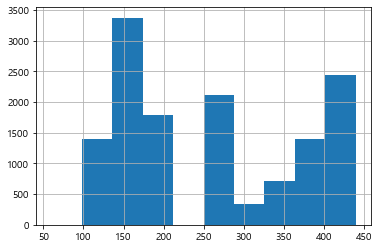

In [42]:
user_df_3[(user_df_3["신용점수등급"] == 10) &
                  (user_df_3["개인회생자"] == 0)]["한도조회_당시_유저_신용점수"].hist()

<AxesSubplot:>

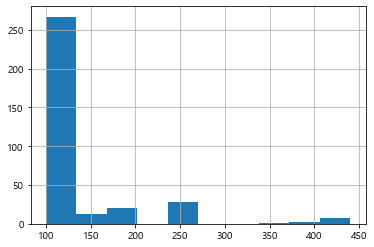

In [43]:
user_df_3[(user_df_3["신용점수등급"] == 10) &
                  (user_df_3["개인회생자"] == 2)]["한도조회_당시_유저_신용점수"].hist()

<AxesSubplot:>

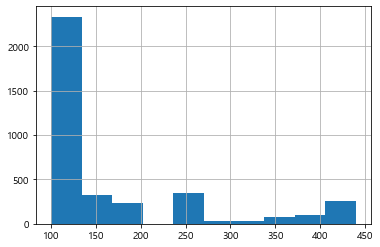

In [44]:
user_df_3[(user_df_3["신용점수등급"] == 10) &
                  (user_df_3["개인회생자"] == 1)]["한도조회_당시_유저_신용점수"].hist()

In [45]:
user_df_3_null1 = user_df_3_null[user_df_3_null["한도조회_당시_유저_신용점수"] < 150]
user_df_3_null2 = user_df_3_null[user_df_3_null["한도조회_당시_유저_신용점수"] >= 150]

user_df_3_null1["개인회생자"] = 1
user_df_3_null2["개인회생자"] = 0

In [46]:
user_df_3_complete = pd.concat([user_df_3_nonull2,user_df_3_nonull1,user_df_3_null1,user_df_3_null2],axis=0)

##### 기대출수 먼저 이상치 잡기
##### 대출희망금액 먼저 이상치 잡기

In [47]:
def find_outlier_z(data):
    
    threshold = 3
    
    mean = np.mean(data)
    std = np.std(data)
    
    z_score = [(y-mean) / std for y in data]
    
    masks = np.where(np.abs(z_score) >= threshold)
    
    #print(mean+threshold*std)
    #print(mean-threshold*std)
    return masks[0]

In [48]:
def no_outlier_z(data):
    
    threshold = 3
    
    mean = np.mean(data)
    std = np.std(data)
    
    z_score = [(y-mean) / std for y in data]
    
    masks = np.where(np.abs(z_score) < threshold)
    
    #print(mean+threshold*std)
    #print(mean-threshold*std)
    return masks[0]

결측을 채울 기준이 되는 dataframe
- 기준이 되는 dataframe : standard_df

In [49]:
def iqr_func(x):
    q3, q1 = np.percentile(x, [75, 25])
    iqr = q3 - q1
    final = q3 + 1.5*iqr
    return int(final)

In [50]:
def get_replace_outlier(data,col):
    # col에 해당하는 이상치 대체하기
    # data : 이상치 대체할 데이터프레임
    
    df = data.copy()
    
    # 이상치 대체의 기준 dataframe
    standard_df = df[df[col].notnull()].groupby(["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"]
                               ).agg({col: iqr_func}).reset_index()
    
    # 이상치의 index
    outlier_index = find_outlier_z(df[col])
    
    # 이상치 아닌 것 index
    nooutlier_index = no_outlier_z(df[col])
    
    # 이상치에 속하는 데이터
    outlier_data = df.loc[outlier_index,:]
    
    # 이상치가 아닌 것에 속하는 데이터
    nooutlier_data = df.loc[nooutlier_index,:]
    
    # 이상치가 대체된 데이터프레임
    
    outlier_replace = pd.merge(outlier_data.drop(col,axis=1),
              
              standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득분위",col]]
         
         ,on=["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"],how="inner")

    
    # 이상치 대체하고나서 concat해주기
    final = pd.concat([outlier_replace[df.columns],
           nooutlier_data,
          df[df[col].isnull()]],
         axis = 0)
    
    
    return final.reset_index(drop=True)

##### user_df_4 : column의 이상치가 처리된 dataframe

In [51]:
user_df_4 = get_replace_outlier(user_df_3_complete,"기대출수")

user_df_4 = get_replace_outlier(user_df_4,"기대출금액")

user_df_4 = get_replace_outlier(user_df_4,"대출희망금액")

user_df_4 = get_replace_outlier(user_df_4,"연소득")

##### user_df_5 : 연소득 0원 이상치가 처리된 dataframe

In [52]:
user_df_5 = user_df_4.copy()
user_df_5[user_df_5["대출희망금액"] == 0]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,주거소유형태,대출희망금액,대출_목적,기대출수,기대출금액,개인회생자,신용점수등급,연소득분위
105,403583,802766,1980.0,1.0,2022-06-13 15:48:30,620.0,28500.0,EARNEDINCOME,20110201.0,정규직,자가,0.0,생활비,7.0,78600.0,0,7,10
106,1869885,802766,1980.0,1.0,2022-06-13 15:49:53,620.0,28500.0,EARNEDINCOME,20110201.0,정규직,자가,0.0,생활비,7.0,78600.0,0,7,10
259,688854,580934,1978.0,1.0,2022-03-12 10:17:15,940.0,28500.0,EARNEDINCOME,200909.0,정규직,자가,0.0,생활비,1.0,900.0,0,1,10
653,1341046,732757,1982.0,1.0,2022-05-06 10:29:46,650.0,34000.0,EARNEDINCOME,200801.0,정규직,전월세,0.0,생활비,4.0,1800.0,0,7,10
1486,2161187,134906,1983.0,1.0,2022-04-17 17:38:55,200.0,52500.0,PRIVATEBUSINESS,202112.0,정규직,전월세,0.0,생활비,1.0,8027.0,0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385918,2030642,378579,NaN,1.0,2022-06-12 21:39:52,700.0,2300.0,EARNEDINCOME,20161201.0,정규직,전월세,0.0,생활비,3.0,3000.0,0,6,2
1386528,1494840,714122,NaN,0.0,2022-06-26 15:12:27,920.0,0.0,EARNEDINCOME,20220626.0,정규직,기타가족소유,0.0,기타,1.0,1500.0,0,1,0
1386546,84580,543558,NaN,1.0,2022-06-27 09:31:26,650.0,2000.0,FREELANCER,20210627.0,기타,전월세,0.0,기타,7.0,3900.0,0,7,2
1386568,334580,607766,NaN,1.0,2022-06-27 13:26:17,630.0,200.0,EARNEDINCOME,20211014.0,정규직,전월세,0.0,생활비,1.0,800.0,0,7,2


#### 연소득 0원 데이터 처리하기
- OTHERINCOME 기타소득을 제외하곤 연소득 0원을 평균으로 대체하기

In [53]:
user_df_5[user_df_5["연소득"] == 0]["근로형태"].value_counts()

OTHERINCOME        14881
FREELANCER          1117
PRIVATEBUSINESS      635
EARNEDINCOME         499
EARNEDINCOME2        177
PRACTITIONER          20
Name: 근로형태, dtype: int64

- 근로형태에 따라서 하나씩 평균값 대입

In [54]:
df_lst = []

for work_type in ['FREELANCER', 'PRIVATEBUSINESS', 'EARNEDINCOME', 'EARNEDINCOME2',
       'PRACTITIONER']:
    
    # 연소득 0원 채워야하는 데이터
    replaced = user_df_5[(user_df_5["연소득"] == 0) & (user_df_5["근로형태"] == work_type)]

    # 연소득 0원이 아닌 데이터
    no_replace = user_df_5[(user_df_5["연소득"] != 0) & (user_df_5["근로형태"] == work_type)]
    
    standard_df = user_df_5.groupby(["유저_성별","근로형태","고용형태","주거소유형태"]).mean().reset_index()
   
    # 0값이 처리된 데이터
    zero_replace = pd.merge(replaced.drop("연소득",axis=1),

                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득"]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태"],how="inner")

    zero_replace = zero_replace[user_df_5.columns] # 0값이 처리된 데이터
    zero_replace["연소득"] = zero_replace["연소득"].astype(int)
    
    print(work_type,"전처리 끝")
    
    df_lst.append(zero_replace)
    df_lst.append(no_replace)
    
df_lst.append(user_df_5[user_df_5["근로형태"] == "OTHERINCOME"])

FREELANCER 전처리 끝
PRIVATEBUSINESS 전처리 끝
EARNEDINCOME 전처리 끝
EARNEDINCOME2 전처리 끝
PRACTITIONER 전처리 끝


#### 대출희망금액 0원 전처리
- "유저_성별","근로형태","고용형태","주거소유형태","연소득분위" 기반 평균으로 대체
- 그래도 0이면?
- "유저_성별","근로형태","고용형태","주거소유형태" 기반 평균으로 대체

In [55]:
user_df_5 = pd.concat(df_lst,axis=0).reset_index(drop=True)

In [64]:
user_df_5.shape

(1386760, 18)

In [65]:
user_df_5[user_df_5["대출희망금액"] == 0]["근로형태"].value_counts()

EARNEDINCOME       2131
OTHERINCOME        1429
FREELANCER          299
EARNEDINCOME2       207
PRIVATEBUSINESS     113
PRACTITIONER         58
Name: 근로형태, dtype: int64

In [56]:
# 대출희망금액 0원 채워야하는 데이터
replaced = user_df_5[(user_df_5["대출희망금액"] == 0)]

# 대출희망금액 0원이 아닌 데이터
no_replace = user_df_5[(user_df_5["대출희망금액"] != 0)]
    
standard_df = user_df_5.groupby(["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"]).mean().reset_index()

In [57]:
# 0값이 처리된 데이터
zero_replace = pd.merge(replaced.drop("대출희망금액",axis=1),
                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득분위","대출희망금액"]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"],how="inner")

zero_replace = zero_replace[user_df_5.columns] # 0값이 처리된 데이터
zero_replace["대출희망금액"] = zero_replace["대출희망금액"].astype(int)

In [58]:
user_df_5 = pd.concat([zero_replace,no_replace],axis=0).reset_index(drop=True)

"유저_성별","근로형태","고용형태","주거소유형태" 기반 평균으로 대체

In [59]:
# 대출희망금액 0원 채워야하는 데이터
replaced = user_df_5[(user_df_5["대출희망금액"] == 0)]

# 대출희망금액 0원이 아닌 데이터
no_replace = user_df_5[(user_df_5["대출희망금액"] != 0)]
    
standard_df = user_df_5.groupby(["유저_성별","근로형태","고용형태","주거소유형태"]).mean().reset_index()

# 0값이 처리된 데이터
zero_replace = pd.merge(replaced.drop("대출희망금액",axis=1),
                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","대출희망금액"]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태"],how="inner")

zero_replace = zero_replace[user_df_5.columns] # 0값이 처리된 데이터
zero_replace["대출희망금액"] = zero_replace["대출희망금액"].astype(int)

user_df_5 = pd.concat([zero_replace,no_replace],axis=0).reset_index(drop=True)

############### 이상치 처리 끝 #####################

## 생년월일 이상치 처리

In [60]:
user_df_5 = get_replace_null_(user_df_5,'유저_생년월일')
user_df_5['유저_생년월일'] = user_df_5['유저_생년월일'].astype(int)

## 입사연월 이상치 및 결측치 처리

In [61]:
# 17만명중 600명만 입사연월이 있음 -> 이상치로 보고 모두 입사연월 제거
user_df_5.loc[user_df_5['근로형태']=='OTHERINCOME','입사연월'] ='nan'

In [62]:
user_df_5[user_df_5['입사연월'].isnull()]['근로형태'].value_counts()

EARNEDINCOME       7
PRIVATEBUSINESS    3
Name: 근로형태, dtype: int64

In [63]:
#입사연월은 평균값이 안됨 -> 최빈값으로 대체
user_list = list(user_df_5[(user_df_5['입사연월'].isnull())&(user_df_5['근로형태']=='EARNEDINCOME')]['유저_번호'].index)+list(user_df_5[(user_df_5['입사연월'].isnull())&(user_df_5['근로형태']=='PRIVATEBUSINESS')]['유저_번호'].index)
for i in user_list:
    user_df_5.iloc[i,8] = user_df_5[(user_df_5['근로형태']==user_df_5.iloc[i,7])&(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])&(user_df_5['유저_성별']==user_df_5.iloc[i,3])]['입사연월'].mode()[0]

In [64]:
#생성일시 datetime으로 변경
user_df_5['생성일시_연월'] = user_df_5['생성일시'].str[:7]
user_df_5['생성일시_연월'] = user_df_5['생성일시_연월'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
user_df_5['생성일시_연월'] = pd.to_datetime(user_df_5['생성일시_연월'],format = '%Y%m')

In [65]:
#입사연월 datetime으로 변경
user_df_5['입사연월_연월'] = user_df_5['입사연월'].astype(str).str[:6]
user_df_5.loc[user_df_5['입사연월_연월']=='nan','입사연월_연월'] = '202301'# nan값인 데이터들 처리
user_df_5.loc[user_df_5['입사연월'].isnull(),'입사연월'] = '202301'
user_df_5['입사연월_연월'] = pd.to_datetime(user_df_5['입사연월_연월'],format = '%Y%m')

유저_생년월일보다 입사연월_연월이 더 빠른경우->   
 [유저_생년월일,유저_성별,근로형태,고용형태]를 기준으로 최빈값 넣기

In [66]:
user_df_5['유저_생년월일'] = pd.to_datetime(user_df_5['유저_생년월일'],format = '%Y') #유저 생년월일 datetime으로 변경
temp_list =set(user_df_5[user_df_5['유저_생년월일']>user_df_5['입사연월_연월']]['신청서_번호'])#유저 생년월일이 입사연월보다 빠른 유저 리스트
temp = list(user_df_5[user_df_5['신청서_번호'].isin(temp_list)].index)
for i in temp:
    user_df_5.iloc[i,-1] = user_df_5[(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])
                                              &(user_df_5['유저_성별']==user_df_5.iloc[i,3])
                                              &(user_df_5['근로형태']==user_df_5.iloc[i,7])
                                              &(user_df_5['고용형태']==user_df_5.iloc[i,9])]['입사연월_연월'].mode()[0]

In [67]:
from datetime import datetime
def diff_month(x): # 입사개월 계산 함수
    return (x[0].year - x[1].year) * 12 + x[0].month - x[1].month + 1
def diff_year(x): # 년차 계산 함수
    return x[0].year - x[1].year

In [79]:
user_df_5.columns

Index(['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득',
       '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '기대출수', '기대출금액',
       '개인회생자', '신용점수등급', '연소득분위', '생성일시_연월', '입사연월_연월'],
      dtype='object')

In [68]:
user_df_5['입사개월'] = user_df_5[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
# 입사연월이 생성일시보다 빠르게 들어간 3명 최빈값으로 처리
user_list = list(user_df_5[(user_df_5['입사개월']<0)&(user_df_5['근로형태']!='OTHERINCOME')]['신청서_번호'].index)
for i in user_list:
    user_df_5.iloc[i,-2] = user_df_5[(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])
                                              &(user_df_5['유저_성별']==user_df_5.iloc[i,3])
                                              &(user_df_5['근로형태']==user_df_5.iloc[i,7])
                                              &(user_df_5['고용형태']==user_df_5.iloc[i,9])]['입사연월_연월'].mode()[0]

In [69]:
user_df_5['입사개월'] = user_df_5[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
user_df_5['입사개월'] = user_df_5['입사개월'].astype(int)
user_df_5.loc[user_df_5['입사개월']<1,'입사개월'] = 0# 입사연월이 없는 otherincome 유저들은 0으로 mapping


In [70]:
user_df_5['입사나이'] = user_df_5[['입사연월_연월','유저_생년월일']].apply(diff_year,axis =1)#입사나이
user_df_5[user_df_5['입사나이']<15]['근로형태'].value_counts()


PRIVATEBUSINESS    275
EARNEDINCOME       187
FREELANCER          54
EARNEDINCOME2       16
PRACTITIONER         9
Name: 근로형태, dtype: int64

In [71]:
# 법적 근무나이인 만 15세 이하인 유저들 중 사업과 프리랜서를 제외한 212명은 최빈값으로 처리
user_list = list(user_df_5[(user_df_5['입사나이']<15)&(user_df_5['근로형태']!='PRIVATEBUSINESS')&(user_df_5['근로형태']!='FREELANCER')]['신청서_번호'].index)
for i in user_list:
    user_df_5.iloc[i,-3] = user_df_5[(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])
                                              &(user_df_5['유저_성별']==user_df_5.iloc[i,3])
                                              &(user_df_5['근로형태']==user_df_5.iloc[i,7])
                                              &(user_df_5['고용형태']==user_df_5.iloc[i,9])]['입사연월_연월'].mode()[0]

In [72]:
#입사연월 변경으로 인한 입사개월 다시 계산 
user_df_5['입사개월'] = user_df_5[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
user_df_5['입사개월'] = user_df_5['입사개월'].astype(int)
user_df_5.loc[user_df_5['입사개월']<1,'입사개월'] = 0# 입사연월이 없는 otherincome 유저들은 0으로 mapping

In [73]:
user_df_5['나이'] = user_df_5[['생성일시_연월','유저_생년월일']].apply(diff_year,axis =1)#나이
user_df_5['나이'] = user_df_5['나이'].astype(int)

In [86]:
user_df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386760 entries, 0 to 1386759
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   신청서_번호           1386760 non-null  int64         
 1   유저_번호            1386760 non-null  int64         
 2   유저_생년월일          1386760 non-null  datetime64[ns]
 3   유저_성별            1386760 non-null  float64       
 4   생성일시             1386760 non-null  object        
 5   한도조회_당시_유저_신용점수  1386760 non-null  float64       
 6   연소득              1386760 non-null  float64       
 7   근로형태             1386760 non-null  object        
 8   입사연월             1386760 non-null  object        
 9   고용형태             1386760 non-null  object        
 10  주거소유형태           1386760 non-null  object        
 11  대출희망금액           1386760 non-null  float64       
 12  대출_목적            1386760 non-null  object        
 13  기대출수             1386760 non-null  float64       
 14  기대

In [87]:
user_df_5.columns

Index(['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득',
       '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '기대출수', '기대출금액',
       '개인회생자', '신용점수등급', '연소득분위', '생성일시_연월', '입사연월_연월', '입사개월', '입사나이', '나이'],
      dtype='object')

## 병합용 데이터 처리

In [74]:
temp = user_df_5[['신청서_번호', '유저_번호', '유저_성별','근로형태', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '기대출수', '기대출금액',
       '개인회생자', '신용점수등급', '연소득분위', '입사개월', '나이']]

In [75]:
temp['기대출금액'] = round(temp['기대출금액'],-3)
temp['대출희망금액'] = round(temp['대출희망금액'],-3)

In [79]:
loan_df_train = loan_df[loan_df['신청_여부(타겟)'].notnull()]

In [89]:
# df= pd.merge(temp,loan_df,how ='inner',on = '신청서_번호')
clustering_df = pd.merge(temp,loan_df_train, how='left', left_on='신청서_번호', right_on='신청서_번호')

In [97]:
# clustering_df.to_csv('clustering_df.csv')
# df.to_csv('prediction_df.csv')